In [1]:
import numpy as np
import pandas as pd
import os

from stable_baselines3 import DQN, PPO, A2C
# from sb3_contrib import QRDQN
from stable_baselines3.common.env_checker import check_env

from utils import preprocessing
from utils.feature_enginner import FeatureEngineer
from utils.data_loader import DataLoader
from models.features_extractor import CustomCNN
from envs.trading_env import SimpleTradingEnv
from envs.base import BaseTradingEnv



Loading BokehJS ...

In [2]:
window_size = 20
fee = 0.000665

In [ ]:
# from enum import Enum
# class Actions(Enum):
#     Sell = 0
#     Buy = 1
#     Hold = 2

In [3]:
class TradingEnv(BaseTradingEnv):
    def _calculate_reward(self):
        # reward = 0.0
        reward = self.position.profit_or_loss_pct - self.prev_profit_or_loss_pct
        if self.closed_trades.empty:
            return reward

        trade = self.closed_trades.iloc[-1, :]
        return reward if trade["ExitTime"] != self.current_datetime else trade["ReturnPct"]
    # def _calculate_reward(self):
    #     reward = (self.wallet.equity - self.prev_equity) / self.prev_equity
    #     return reward

In [4]:
# def preprocessing(candles):
#     df = pd.DataFrame()
#     price = candles["Close"]
#     df["diff_price_pct"] = price.pct_change(1)
#     df = df.fillna(0)
#     print(df.head())
#     return df

In [5]:
df = DataLoader.load_data("./data/3600/ethusd/2021-01-01.csv")
train_df = df[: len(df) // 2]
eval_df = df[len(df) // 2 :]

feature_enginner = FeatureEngineer([])
train_features = feature_enginner.preprocessing(train_df)
eval_features = feature_enginner.preprocessing(eval_df)
train_env = TradingEnv(train_df, train_features, window_size=window_size, fee=fee)
eval_env = TradingEnv(eval_df, eval_features, window_size=window_size, fee=fee)
check_env(train_env)

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [6]:
# policy_kwargs = dict(
#     features_extractor_class=CustomCNN,
#     features_extractor_kwargs=dict(features_dim=32),
# )
# model = PPO("CnnPolicy", train_env, verbose=0, tensorboard_log="./logs", policy_kwargs=policy_kwargs)
# model = PPO("MlpPolicy", train_env, verbose=1, tensorboard_log="./logs")
model_class = DQN
model = model_class("MlpPolicy", train_env, verbose=0, tensorboard_log="./logs").learn(30000)
model_name = model.__class__.__name__
model.save(f"./results/{model_name}")
del model

In [7]:
model = model_class.load(f"./results/{model_name}")
print(model)

In [8]:
from stable_baselines3.common.evaluation import evaluate_policy
# episode_rewards, episode_lengths = evaluate_policy(model, train_env, return_episode_rewards=True, deterministic=False)
# mena_reward, std_reward = evaluate_policy(model, train_env, return_episode_rewards=False, deterministic=False)
mean_reward, std_reward = evaluate_policy(model, eval_env, return_episode_rewards=False, deterministic=True)
print(mean_reward, std_reward)

-0.4565584068186581 0.0


[ 0.          0.          0.         ...  0.          0.
 -0.26025467]


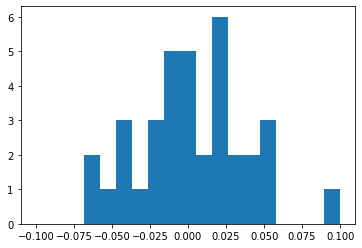

In [9]:
import matplotlib.pyplot as plt
def evaluate(model, env, render=True) -> np.ndarray:
    state = env.reset()
    done = False

    episode_rewards = []

    while not done:
        action, state = model.predict(state)
        state, reward, done, info = env.step(action)

        if render:
            env.render()

        episode_rewards.append(reward)

        if done:
            break

    return np.array(episode_rewards)


episode_rewards = evaluate(model, eval_env, render=False)
print(episode_rewards)
episode_rewards = episode_rewards[~(episode_rewards == 0)]
fig, axs = plt.subplots(1, 1)
bins = np.linspace(-0.1, 0.1, 20)
n, bins, patches = axs.hist(episode_rewards, bins=bins)

In [10]:
from utils import backtest

In [11]:
stats_train = backtest(model, train_env, plot=True, plot_filename=f"./results/BackTest-{model_name}-train")
stats_eval = backtest(model, eval_env, plot=True, plot_filename=f"./results/BackTest-{model_name}-eval")

stats = pd.DataFrame()
stats["train"] = stats_train
stats["eval"] = stats_eval
# stats = stats.drop(["Best Trade [%]", "Worst Trade [%]", "_strategy", "_equity_curve", "_trades"], axis=0)
stats

,train,eval
Start,2021-01-01 00:00:00,2021-04-01 00:00:00
End,2021-03-31 23:00:00,2021-06-30 00:00:00
Duration,89 days 23:00:00,90 days 00:00:00
Exposure Time [%],88.564815,76.584914
Equity Final [$],221246.654646,496708.917572
Equity Peak [$],1011883.377094,1040142.657424
Return [%],-77.875335,-50.329108
Buy & Hold Return [%],149.948745,21.191475
Return (Ann.) [%],-99.779651,-93.959564
Volatility (Ann.) [%],6550.141516,3703.114018


In [12]:
stats.loc["_strategy", "train"].env.closed_trades

,Size,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime
0,-1299,769.268096,1285.0,-669935.742906,-0.670419,2021-01-03 01:00:00,2021-01-26 23:00:00
1,-250,1319.521934,1726.0,-101619.516500,-0.308049,2021-01-28 22:00:00,2021-02-11 16:00:00
2,-127,1797.603798,1620.8,22454.082346,0.098355,2021-02-12 00:00:00,2021-02-26 02:00:00
3,-169,1477.616731,1610.7,-22491.072461,-0.090066,2021-02-26 10:00:00,2021-03-03 19:00:00
4,-140,1625.018643,1542.0,11622.610090,0.051088,2021-03-04 03:00:00,2021-03-06 22:00:00
5,-138,1735.345227,1917.7,-25164.958605,-0.105083,2021-03-11 19:00:00,2021-03-14 08:00:00
6,-113,1897.137564,1553.8,38797.144732,0.180977,2021-03-14 16:00:00,2021-03-25 11:00:00
7,-157,1608.929350,1828.7,-34503.992050,-0.136594,2021-03-25 19:00:00,2021-03-31 23:00:00


In [13]:
stats.loc["_trades", "train"]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,-1299,49,623,769.268096,1285.0,-669935.742906,-0.670419,2021-01-03 01:00:00,2021-01-26 23:00:00,23 days 22:00:00
1,-250,670,1000,1319.521934,1726.0,-101619.516500,-0.308049,2021-01-28 22:00:00,2021-02-11 16:00:00,13 days 18:00:00
2,-127,1008,1346,1797.603798,1620.8,22454.082346,0.098355,2021-02-12 00:00:00,2021-02-26 02:00:00,14 days 02:00:00
3,-169,1354,1483,1477.616731,1610.7,-22491.072461,-0.090066,2021-02-26 10:00:00,2021-03-03 19:00:00,5 days 09:00:00
4,-140,1491,1558,1625.018643,1542.0,11622.610090,0.051088,2021-03-04 03:00:00,2021-03-06 22:00:00,2 days 19:00:00
5,-138,1675,1736,1735.345227,1917.7,-25164.958605,-0.105083,2021-03-11 19:00:00,2021-03-14 08:00:00,2 days 13:00:00
6,-113,1744,2003,1897.137564,1553.8,38797.144732,0.180977,2021-03-14 16:00:00,2021-03-25 11:00:00,10 days 19:00:00
7,-157,2011,2158,1608.929350,1815.4,-32415.892050,-0.128328,2021-03-25 19:00:00,2021-03-31 22:00:00,6 days 03:00:00
